# HW 1
writtern by JungYoung</br>
Last updated, 200911

In [345]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as anim

## 1 oscillator

In [251]:
class Oscillator:
    def __init__(self, k, L, dt=0.01):
        self.k = k # spring constant
        self.L = L # length of the spring
        self.m = 1
        self.dt = dt # time interval
    
    def run_osc(self, d, tmax):
        # save init value
        self.d = d
        self.v = 0
        self.tmax = tmax
        # init array
        self.itr = int(self.tmax/self.dt)+1
        self._init_array(self.d, self.v, self.itr)
        # run
        for i in range(1, self.itr):
            self.x_list[i], self.v_list[i] = self.run_once(self.x_list[i-1], self.v_list[i-1], self.f_osc)
        self.x_list = self.x_list + self.L
        print("Done")

    def f_osc(self, x):
        return -self.k/self.m * x # dx2/dt2 = -k * x

    def f_dx(self, v):
        return v

    def get_dx(self, x, fn):
        # use RK4 method
        k1 = self.dt * fn(x)
        k2 = self.dt * fn(x+k1/2)
        k3 = self.dt * fn(x+k2/2)
        k4 = self.dt * fn(x+k3)
        return k1/6+k2/3+k3/3+k4/6 # dx

    def run_once(self, x, v, f):
        dv = self.get_dx(x, f)
        v = v + dv
        dx = self.get_dx(v, self.f_dx)
        x = x + dx
        return x, v

    def _init_array(self, x0, v0, itr):
        self.t_list = np.arange(itr)*self.dt
        self.x_list = np.zeros(itr)
        self.v_list = np.zeros(itr)
        self.x_list[0] = x0
        self.v_list[0] = v0

# analytics solution
class OscSolution:
    def __init__(self, class_obj):
        self._copy_const(class_obj)

    def solve_eq(self):
        self.t_list = np.arange(0, self.tmax+self.dt/2, self.dt)
        km = np.sqrt(self.k/self.m)
        self.v_list = -self.d * km*np.sin(km*self.t_list)
        self.x_list = self.d * np.cos(km*self.t_list) + self.L

    def _copy_const(self, class_obj):
        self.x0 = class_obj.x_list[0]
        self.v0 = class_obj.v_list[0]
        self.k = class_obj.k
        self.d = class_obj.d
        self.L = class_obj.L
        self.m = class_obj.m
        self.tmax = class_obj.tmax
        self.dt = class_obj.dt


In [252]:
osc1 = Oscillator(4, 2, dt=0.001)

In [253]:
osc1.run_osc(2, 20)
osc2 = OscSolution(osc1)
osc2.solve_eq()

Done


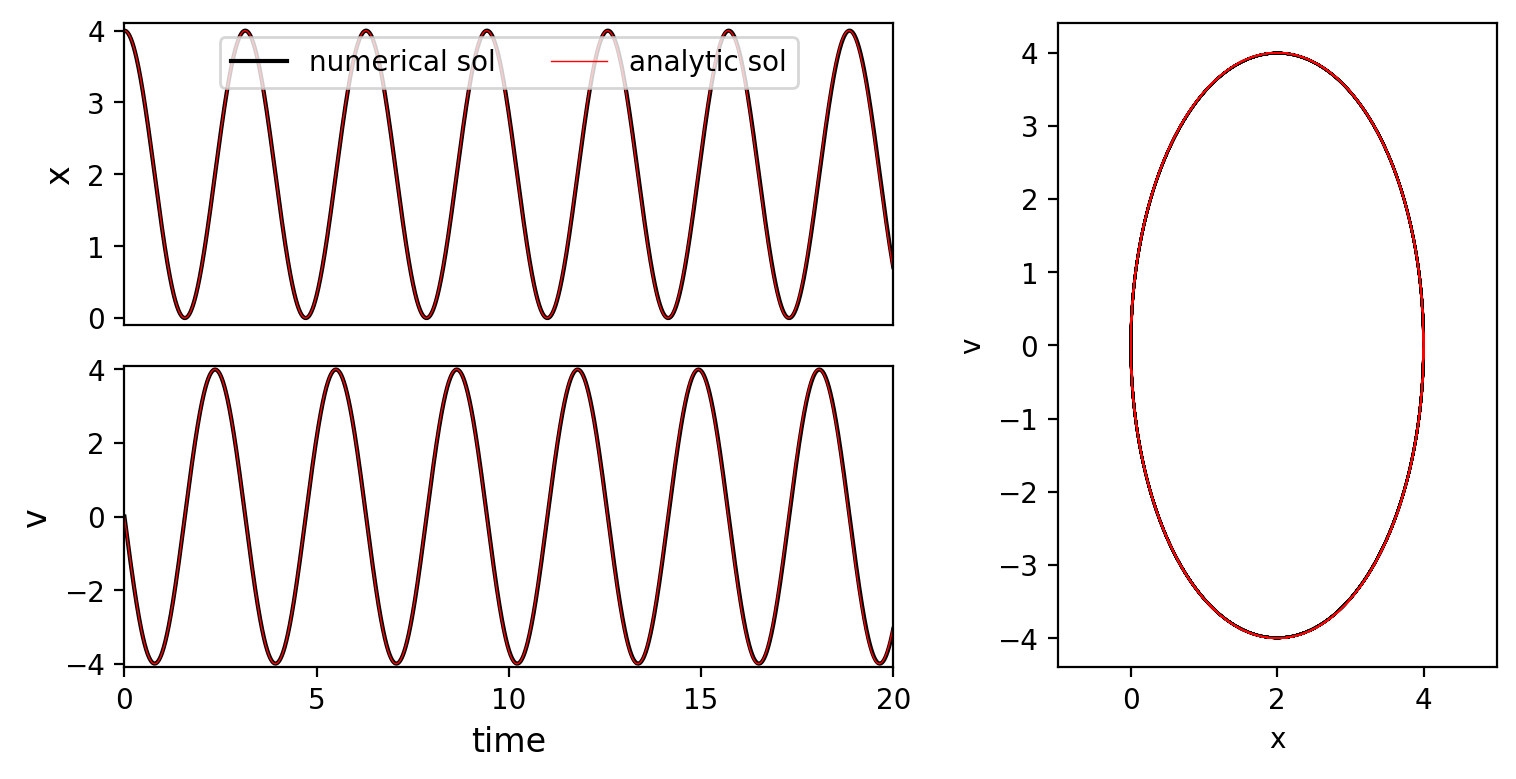

In [254]:
fig = plt.figure(dpi=200, figsize=(8, 4))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 2])
ax1 = fig.add_subplot(gs[0, 0])
plt.plot(osc1.t_list, osc1.x_list, "k", label="numerical sol")
plt.plot(osc2.t_list, osc2.x_list, "r", label="analytic sol", lw=0.5)
plt.legend(fontsize=10, loc=9, ncol=2)
plt.xlim([0, osc1.t_list[-1]])
plt.ylim([-osc1.d+osc1.L-0.1, osc1.d+osc1.L+0.1])
plt.ylabel("x", fontsize=12)
plt.xticks([])

ax2 = fig.add_subplot(gs[1, 0])
plt.plot(osc1.t_list, osc1.v_list, "k", label="numerical sol")
plt.plot(osc2.t_list, osc2.v_list, "r", label="analytic sol", lw=0.5)
plt.xlim([0, osc1.t_list[-1]])
plt.ylim([-osc1.d*np.sqrt(osc1.k/osc1.m)-0.1, osc1.d*np.sqrt(osc1.k/osc1.m)+0.1])
plt.xlabel("time", fontsize=12)
plt.ylabel("v", fontsize=12)
plt.xticks(np.arange(0, osc1.t_list[-1]+1, 5))

ax3 = fig.add_subplot(gs[:, 1])
plt.plot(osc1.x_list, osc1.v_list*osc1.m, "k", lw=1)
plt.plot(osc2.x_list, osc2.v_list*osc1.m, "r", lw=0.5)
plt.axis("square")
plt.xlim([-osc1.d+osc1.L-1, osc1.d+osc1.L+1])
plt.xlabel("x")
plt.ylabel("v")

plt.tight_layout()
plt.show()

## 2 oscillator

In [333]:
class multiOscillator(Oscillator):
    def __init__(self, k_list, L_list, dt=0.01):
        self.dt = dt
        self.k_list = k_list
        self.L_list = L_list
        self.N = len(self.k_list)
        self._create_oscs()

    def _create_oscs(self):
        self.oscs = []
        for k, L in zip(self.k_list, self.L_list):
            self.oscs.append(Oscillator(k, L, self.dt))

    def run_osc(self, d, tmax):
        # save init value
        self.d_list = np.zeros(self.N)
        self.d_list[-1] = d  # extend last oscillator
        self.v = 0
        self.tmax = tmax
        # init array
        self.itr = int(self.tmax/self.dt)+1
        x0 = 0
        for i, osc in enumerate(self.oscs):
            osc._init_array(self.d_list[i], self.v, self.itr)
        self.t_list = self.oscs[0].t_list
        # run
        for i in range(1, self.itr):
            self.read_locs(i-1)
            # update for all oscillator
            for n, osc in enumerate(self.oscs):
                if n == 0:
                    f = lambda x: self.f_osc_multi(self.k_list[n], self.k_list[n+1], 0, x, self.x_osc[n+1])
                elif n == self.N-1:
                    f = lambda x: self.f_osc_multi(self.k_list[n], 0, self.x_osc[n-1], x, 0)
                else:
                    f = lambda x: self.f_osc_multi(self.k_list[n], self.k_list[n+1], self.x_osc[n-1], x, self.x_osc[n+1])
                osc.x_list[i], osc.v_list[i] = osc.run_once(osc.x_list[i-1], osc.v_list[i-1], f)
        l0 = 0
        for i, osc in enumerate(self.oscs):
            l0 += self.L_list[i]
            osc.x_list += l0
            
        print("Done")
            
    def f_osc_multi(self, k01, k12, x0, x1, x2):
        # x0--k01--x1--k12--x2
        # dx2/dt2 = -k01*(x1-x0) - k12*(x1-x2)
        return -k01*(x1-x0) - k12*(x1-x2)
    
    def read_locs(self, ind):
        self.x_osc = np.zeros(self.N)
        for i in range(self.N):
            self.x_osc[i] = self.oscs[i].x_list[ind]

In [420]:
N = 10
k_list = np.ones(N) # [1, 1, 1]
L_list = np.ones(N)*2 #[2, 2, 2]
osc_multi = multiOscillator(k_list, L_list, dt=0.01)

In [421]:
d = 2
tmax = 100
osc_multi.run_osc(d, tmax)

Done


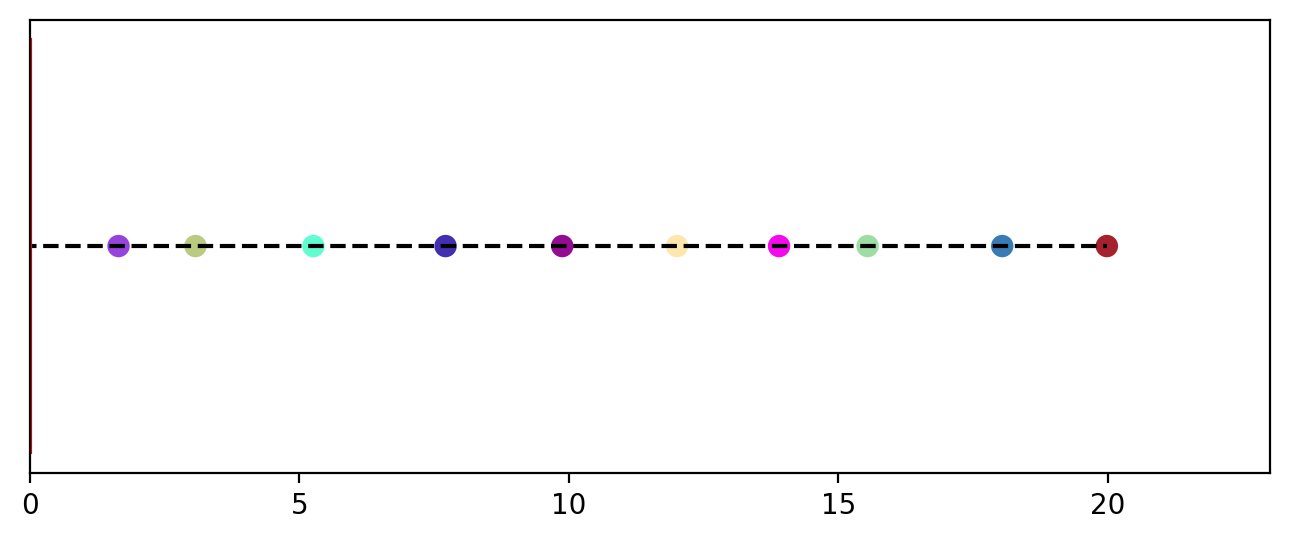

In [431]:
fig, ax = plt.subplots(dpi=200, figsize=(8, 3))
y0 = np.zeros(N+1)
itr = osc_multi.t_list.shape[0]//5
# colors = ["w", "r", "g", "b"]
colors = ["w"]
for i in range(len(k_list)):
    colors.append(np.random.randint(255, size=3)/255)
plt.yticks([])

x_osc = np.concatenate(([-2], [osc_multi.oscs[n].x_list[0] for n in range(N)]))
pl, = plt.plot(x_osc, y0, 'k--')
plt.plot([0, 0], [-1, 1], "r")
s = plt.scatter(x_osc, y0, 50, c=colors, alpha=1)

def init():
    plt.xlim([0, sum(L_list)+d+1])
    pl.set_data(x_osc, y0)
    return pl, s

def update(i):
    x_osc = np.concatenate(([-2], [osc_multi.oscs[n].x_list[i*5] for n in range(N)]))
    pl.set_data(x_osc, y0)
    s.set_offsets(np.c_[x_osc, y0])
    return pl, s

ani = anim.FuncAnimation(fig, update, frames=np.arange(itr), init_func=init, blit=True, interval=100)

# plt.show()
Writer = anim.writers['ffmpeg']
writer = Writer(fps=60, bitrate=1800)
ani.save('multi Oscillator.mp4', writer=writer)